This file investigates QSO TS in stripe 82.

In [19]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [20]:
# this imports my version of skymapper
import sys
sys.path.append('/global/homes/y/yfeng1/source/skymapper')
import aea_projection

In [21]:
# incase it is modified
reload(aea_projection)

<module 'aea_projection' from '/global/u1/y/yfeng1/source/skymapper/aea_projection.pyc'>

In [22]:
import imaginglss
decals = imaginglss.DECALS('/project/projectdirs/m779/imaginglss/dr2.conf.py')

In [23]:
import h5py
import fitsio

In [24]:
dr = decals.datarelease

In [25]:
RA = 340
DEC = 0
# sorry 360.0 gives an extra column of bricks
stripe82 = dr.create_footprint((320, 359.99, DEC-1.25, DEC+1.25 ))

In [26]:
stripe82_DR2 = stripe82.intersect(dr.footprint)

Run this if we need to regenerate the DR2 brick subset that covers stripe 82
```
cat = dr.create_catalogue(stripe82_DR2)
f = h5py.File('stripe82-DR2.hdf5')
ds = f.create_dataset("Objects", data=cat)
f.close()
del ds
del f
```

In [27]:
cat = h5py.File('stripe82-DR2.hdf5')['Objects'][:]

Regenerate the fits file for FITS people
```
!rm '/project/projectdirs/m779/yfeng1/imaginglss/stripe82-DR2.fits'
f = fitsio.FITS('/project/projectdirs/m779/yfeng1/imaginglss/stripe82-DR2.fits', 'rw')
f.write(cat)
```

In [28]:
#define David's Rmag based veto, we will apply it with David's bstars catalogue 

from imaginglss.analysis import veto

david_veto_radius = lambda b : 10.**(3.6 - 0.15 * b['RMAG']) / 3600. 
bstars = fitsio.FITS('/global/project/projectdirs/desi/target/stripe82-dr2/bstars-merge.fits')[1][:]

In [41]:
def analyze(title, data, areamask, vetomask):
    figure(figsize=(9, 3))
    ax = subplot(131)
    _ = ax.hist(data['RA'][areamask], range=(320, 360), bins=100, 
                weights=ones(len(data[areamask])) / (2.5 * 0.4), label='No Veto')
    vmin1 = percentile(_[0], 5) * 0.8
    vmax1 = percentile(_[0], 95) * 1.2
    _ = ax.hist(data['RA'][areamask & ~vetomask], range=(320, 360), bins=100, 
                weights=ones(len(data[areamask & ~vetomask])) / (2.5 * 0.4), label='Veto')
    vmin2 = percentile(_[0], 5) * 0.8
    vmax2 = percentile(_[0], 95) * 1.2

    ax.set_title(title)
    ax.set_xlim(360, 320)
    
    ax = subplot(132, projection='aea')
    _ = ax.histmap(data['RA'][areamask], data['DEC'][areamask], nside=256, perarea=True, vmax=vmax1, vmin=vmin1)
    ax.set_xlim(320, 360)
    ax.set_ylim(-1.25, 1.25)
    ax.set_yticks(linspace(-1.25, 1.25, 5, endpoint=True))
    ax.set_title('No veto')

    ax = subplot(133, projection='aea')
    _ = ax.histmap(data['RA'][areamask & ~vetomask], data['DEC'][areamask & ~vetomask], nside=256, perarea=True, 
                   vmax=vmax1, vmin=vmin1)
    ax.set_xlim(320, 360)
    ax.set_ylim(-1.25, 1.25)
    ax.set_yticks(linspace(-1.25, 1.25, 5, endpoint=True))
    ax.set_title('With Rmag veto')

# Now let's play with the Target definitions

In [42]:
from imaginglss.model.columnnames import *

180328.0
136377.0


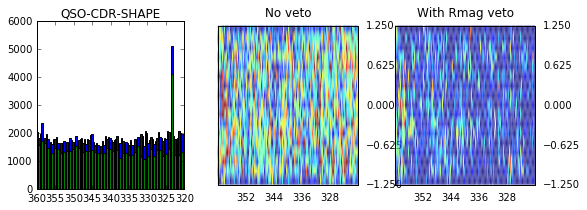

In [43]:
def define_target():
    QSO = BRICK_PRIMARY != 0
    QSO &= Max(SHAPEEXP_R,SHAPEDEV_R) < 0.5
    #QSO &= TYPE == 'PSF '
    QSO &= RFLUX > 10**((22.5-23.0)/2.5)
    QSO &= RFLUX < 10**(1.0/2.5) * GFLUX
    QSO &= ZFLUX > 10**(-0.3/2.5) * RFLUX
    QSO &= ZFLUX < 10**(1.1/2.5) * RFLUX
    QSO &= WFLUX * GFLUX ** 1.2 > 10**(-.4/2.5) * RFLUX ** (1+1.2)
    QSO &= DECAM_ANYMASK[1] == 0
    QSO &= DECAM_ANYMASK[2] == 0
    QSO &= DECAM_ANYMASK[4] == 0
    return QSO
TYPE_QSO_CDR_shape = define_target()
QSO_CDR_shape= TYPE_QSO_CDR_shape(cat)
spatial = (abs(QSO_CDR_shape['DEC']) < 1.25)
v = veto.veto((QSO_CDR_shape['RA'], QSO_CDR_shape['DEC']), 
              (bstars['RA'], bstars['DEC']), 
              david_veto_radius(bstars))
analyze("QSO-CDR-SHAPE", QSO_CDR_shape, spatial, v)

180328.0
136377.0


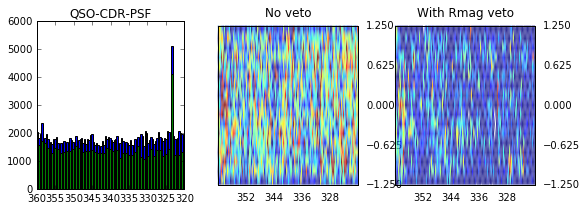

In [45]:
def scope():
    QSO = BRICK_PRIMARY != 0
    QSO &= TYPE == 'PSF '
    QSO &= RFLUX > 10**((22.5-23.0)/2.5)
    QSO &= RFLUX < 10**(1.0/2.5) * GFLUX
    QSO &= ZFLUX > 10**(-0.3/2.5) * RFLUX
    QSO &= ZFLUX < 10**(1.1/2.5) * RFLUX
    QSO &= WFLUX * GFLUX ** 1.2 > 10**(-.4/2.5) * RFLUX ** (1+1.2)
    QSO &= DECAM_ANYMASK[1] == 0
    QSO &= DECAM_ANYMASK[2] == 0
    QSO &= DECAM_ANYMASK[4] == 0
    return QSO
TYPE_QSO_CDR_psf = define_target()
QSO_CDR_psf = TYPE_QSO_CDR_psf(cat)

spatial = (abs(QSO_CDR_psf['DEC']) < 1.25)
v = veto.veto((QSO_CDR_psf['RA'], QSO_CDR_psf['DEC']), 
              (bstars['RA'], bstars['DEC']), 
              david_veto_radius(bstars))
analyze("QSO-CDR-PSF", QSO_CDR_psf, spatial, v)

32291.0
23178.0


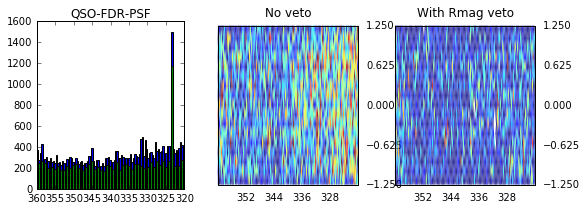

In [46]:
def define_target():
    QSOC  = RFLUX > 10**((22.5-23.0)/2.5)
    QSOC &= GRZFLUX < 10**((22.5-17.0)/2.5)
    QSOC &= RFLUX < 10**(1.3/2.5) * GFLUX
    QSOC &= ZFLUX > 10**(-0.3/2.5) * RFLUX
    QSOC &= ZFLUX < 10**(1.1/2.5) * RFLUX
    QSOC &= WFLUX * GFLUX > 10**(-1.0/2.5) * ZFLUX * GRZFLUX
    QSOC &= W2FLUX > W1FLUX * 10**(-0.4 / 2.5)
    QSOC &= SNRW1 > 4
    QSOC &= SNRW2 > 2

    QSO = BRICK_PRIMARY != 0
    QSO &= QSOC
    QSO &= TYPE == 'PSF '
    return QSO

TYPE_QSO_FDR_psf = define_target()
QSO_FDR_psf = TYPE_QSO_FDR_psf(cat)

spatial = (abs(QSO_FDR_psf['DEC']) < 1.25)
v = veto.veto((QSO_FDR_psf['RA'], QSO_FDR_psf['DEC']), 
              (bstars['RA'], bstars['DEC']), 
              david_veto_radius(bstars))
analyze("QSO-FDR-PSF", QSO_FDR_psf, spatial, v)

98142.0
71588.0


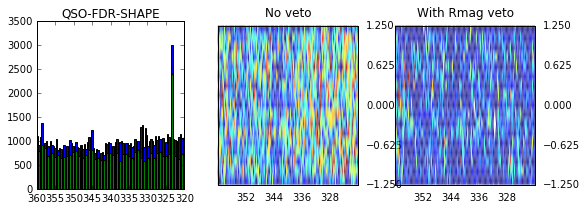

In [47]:
def define_target():
    QSOC  = RFLUX > 10**((22.5-23.0)/2.5)
    QSOC &= GRZFLUX < 10**((22.5-17.0)/2.5)
    QSOC &= RFLUX < 10**(1.3/2.5) * GFLUX
    QSOC &= ZFLUX > 10**(-0.3/2.5) * RFLUX
    QSOC &= ZFLUX < 10**(1.1/2.5) * RFLUX
    QSOC &= WFLUX * GFLUX > 10**(-1.0/2.5) * ZFLUX * GRZFLUX
    QSOC &= W2FLUX > W1FLUX * 10**(-0.4 / 2.5)
    QSOC &= SNRW1 > 4
    QSOC &= SNRW2 > 2

    QSO = BRICK_PRIMARY != 0
    QSO &= QSOC
    QSO &= Max(SHAPEEXP_R,SHAPEDEV_R) < 0.5
    return QSO


TYPE_QSO_FDR_shape = define_target()
QSO_FDR_shape = TYPE_QSO_FDR_shape(cat)

spatial = (abs(QSO_FDR_shape['DEC']) < 1.25)
v = veto.veto((QSO_FDR_shape['RA'], QSO_FDR_shape['DEC']), 
              (bstars['RA'], bstars['DEC']), 
              david_veto_radius(bstars))
analyze("QSO-FDR-SHAPE", QSO_FDR_shape, spatial, v)

107623.0


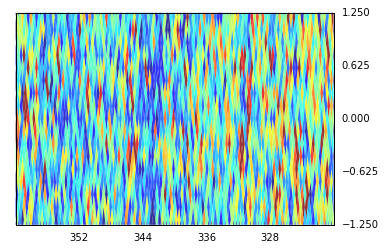

In [88]:
ax = subplot(111, projection='aea')
_ = ax.histmap(data['RA'], data['DEC'], nside=256, perarea=True, vmax=1500, vmin=500)
ax.set_xlim(320, 360)
ax.set_ylim(-1.25, 1.25)
ax.set_yticks(linspace(-1.25, 1.25, 5, endpoint=True))

6628092.0
5399986.0


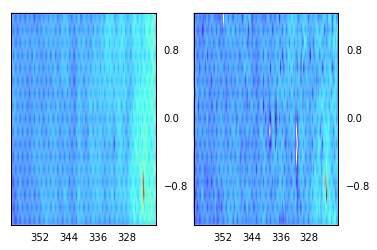

In [52]:
PSFobjs = cat[cat['TYPE'] == 'PSF ']
ax = subplot(121, projection='aea')
ax.histmap(PSFobjs['RA'], PSFobjs['DEC'], nside=256, perarea=True)
ax.set_xlim(320, 360)
ax.set_ylim(-1.25, 1.25)
v = veto.veto((PSFobjs['RA'], PSFobjs['DEC']), (bstars['RA'], bstars['DEC']), david_veto_radius(bstars))
ax = subplot(122, projection='aea')
ax.histmap(PSFobjs['RA'][~v], PSFobjs['DEC'][~v], nside=256, perarea=True)
ax.set_xlim(320, 360)
ax.set_ylim(-1.25, 1.25)

In [15]:
def scope():
    QSO = BRICK_PRIMARY != 0
    QSO &= Max(SHAPEEXP_R,SHAPEDEV_R) < 0.5
    #QSO &= TYPE == 'PSF '
    QSO &= RFLUX > 10**((22.5-23.0)/2.5)
    QSO &= RFLUX < 10**(1.0/2.5) * GFLUX
    QSO &= ZFLUX > 10**(-0.3/2.5) * RFLUX
    QSO &= ZFLUX < 10**(1.1/2.5) * RFLUX
    QSO &= WFLUX * GFLUX ** 1.2 > 10**(-0.4 /2.5) * RFLUX ** (1+1.2)
    QSO &= DECAM_ANYMASK[1] == 0
    QSO &= DECAM_ANYMASK[2] == 0
    QSO &= DECAM_ANYMASK[4] == 0
    return QSO
QSO_david = scope()


In [ ]:
print QSO_david[5](david).shape

In [ ]:
left = QSO_david[1][0].apply(david)
right = QSO_david[1][1].apply(david)
plot(left / right, '. ')
grid()
loglog()


In [ ]:
print QSO_david.apply(david).all()

In [ ]:
print david['SHAPEEXP_R'].min()

In [ ]:
mask = QSO.apply(cat)

In [ ]:
mask &= abs(cat['DEC']) < 1.0

In [ ]:
print mask.sum()


In [ ]:
_ = hist(cat['RA'][mask_david], bins=100, range=(320, 360))

In [ ]:
_ = hist(cat['RA'][mask], bins=100, range=(320, 360))

In [ ]:
PSFMASK = cat['TYPE'] == 'PSF '
_ = hist(cat['RA'][PSFMASK], bins=100, range=(320, 360), weights=ones(PSFMASK.sum()) / (2.5 * 0.4))
title("TYPE == PSF")

In [16]:
print david.shape
print mydata.shape

(134102,)
(198302,)


In [27]:
from scipy.spatial import cKDTree
tree = cKDTree(array((david['RA'], david['DEC'])).T)
d, i = tree.query(array((mydata['RA'], mydata['DEC'])).T, )

In [24]:
from imaginglss.analysis import tycho_veto
reload(tycho_veto)

<module 'imaginglss.analysis.tycho_veto' from '/global/project/projectdirs/m779/yfeng1/source/imaginglss/imaginglss/analysis/tycho_veto.pyc'>

In [25]:
def myveto(tycho):
    return ones_like(tycho['VMAG']) * 500. / 3600.

In [68]:
myveto = lambda self: tycho_veto.DECAM_LRG(self)

In [69]:
#v = decals.tycho.veto((mydata['RA'], mydata['DEC']), tycho_veto.DECAM_LRG)
v = decals.tycho.veto((mydata['RA'], mydata['DEC']), myveto)

In [29]:
david_missing = mydata[(d > 0.0005) & (abs(mydata['DEC']) < 1.25) & ~v]
print(david_missing.shape)

(2739,)


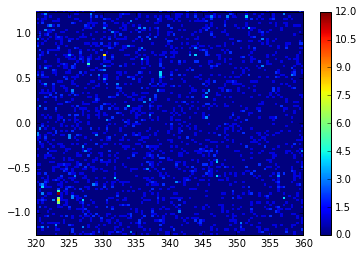

In [30]:
_ = hist2d(david_missing['RA'], david_missing['DEC'], bins=100)
colorbar()
#xlim(330, 335)

['DEV ' 'EXP ' 'PSF ' 'SIMP']


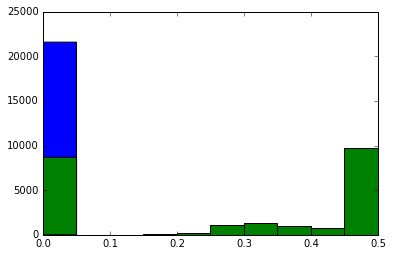

In [43]:
print unique(david_missing['TYPE'])
_ = hist(david_missing['SHAPEDEV_R'])
_ = hist(david_missing['SHAPEEXP_R'])

[]

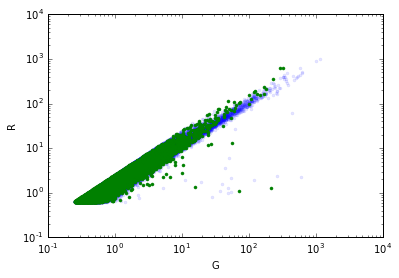

In [50]:
plot(GFLUX.apply(david), RFLUX.apply(david), '. ', alpha=0.1)
plot(GFLUX.apply(david_missing), RFLUX.apply(david_missing), '. ', alpha=1)

xlabel('G')
ylabel('R')
loglog()

[]

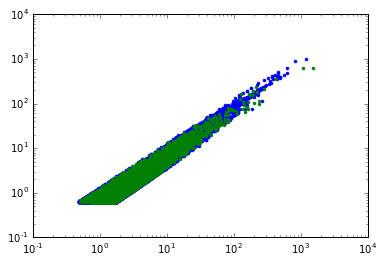

In [51]:
plot(ZFLUX.apply(david), RFLUX.apply(david), '. ')
plot(ZFLUX.apply(david_missing), RFLUX.apply(david_missing), '. ')

loglog()

In [52]:
WFLUXALT = 0.67 * WISE_FLUX[0] / WISE_MW_TRANSMISSION[0] \
      + 0.33 * WISE_FLUX[1] / WISE_MW_TRANSMISSION[1]


[]

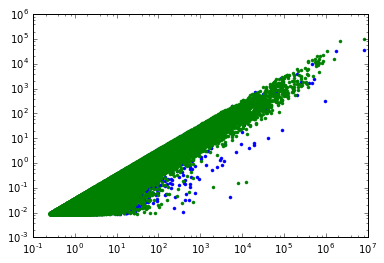

In [53]:
plot((WFLUX * GFLUX ** 1.2).apply(david_missing), (10**(-4/2.5) *RFLUX ** 2.2).apply(david_missing), '. ')
plot((WFLUX * GFLUX ** 1.2).apply(david), (10**(-4/2.5) *RFLUX ** 2.2).apply(david), '. ')

loglog()

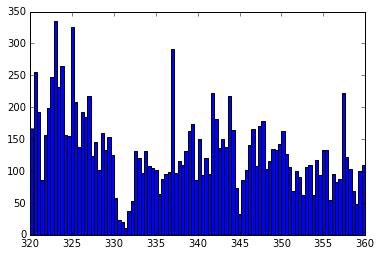

In [54]:
_ = hist(david_missing['RA'], bins=100)

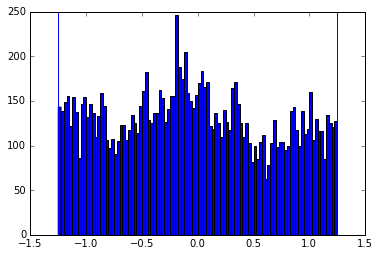

In [55]:
_ = hist(david_missing['DEC'], bins=100)
axvline(1.25)
axvline(-1.25)

cat2file = fitsio.FITS('/global/homes/y/yfeng1/source/imaginglss/tractor-stripe82.fits')[1]
cat2 = numpy.empty(cat2file.get_nrows(), cat.dtype)
for i in range(0, len(cat2), 1024 * 32):
    sl = slice(i, i + 1024 * 32)
    input = cat2file[sl]
    for c in cat2.dtype.names:
        if c == 'BRICK_PRIMARY':
            v = input[c] == 'T'
        elif c == 'DECAM_DEPTH':
            v = 0
        else:
            v = input[c]
            
        cat2[c][sl] = v
    


In [23]:
print ((abs(mydata['DEC']) < 1.25) & ~v).sum()

136377
